In [1]:
#Importing the required libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input)

import os
import cv2
from sklearn.model_selection import train_test_split

In [2]:
dir_path = "E:/Projects/DataSets/archive/Apple vs Orange"

emotions = ['Apple', 'Orange']
images = []
labels = []

for emo in emotions:
    emo_path = os.path.join(dir_path, emo)
    
    for filename in os.listdir(emo_path):
        if filename.endswith(".jpg"):  
            img_path = os.path.join(emo_path, filename)
            img = cv2.imread(img_path)
            
            img = cv2.resize(img, (224, 224))
            
            img_array = np.array(img)
            
            img_array = np.array(img, dtype=np.float32) / 255.0

            images.append(img_array)
            labels.append(emotions.index(emo))  

images = np.array(images)
labels = np.array(labels)


In [3]:
#Shape of each image
images[0].shape

(224, 224, 3)

In [4]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [5]:
#Building the ResNet 50 Architecture
#Custom Conv Layer
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
        super(CustomConv2D,self).__init__(name = 'custom_conv2d')

        self.conv = Conv2D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = 'relu',
            strides = n_strides,
            padding = padding)
        self.batch_norm = BatchNormalization()

    def call(self,x,training = True):
        x = self.conv(x)
        x = self.batch_norm(x, training=training)
        x = Activation('relu')(x) 
        return x


#Residual Block
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides = 1):
        super(ResidualBlock, self).__init__(name='res_block')

        self.dotted = (n_strides != 1)
        self.custom_conv_1 = CustomConv2D(n_channels,1,n_strides,padding = 'same')
        self.custom_conv_2 = CustomConv2D(n_channels,3, 1, padding = 'same')
        self.custom_conv_3 = CustomConv2D(n_channels * 4 ,1, 1, padding = 'same')

        self.activation = Activation('relu')

        if self.dotted:
            self.custom_conv4 = CustomConv2D(n_channels * 4,1,n_strides)

        def call(self, input, training):
            x = self.custom_conv_1(input, training)
            x = self.custom_conv_2(x, training) 
            x = self.custom_conv_3(x, training) 
            if self.dotted:
                x_add = self.custom_conv4(input, training) 
                x_add = Add()([x, x_add])
            else:
                x_add = Add()([x, input])
            return self.activation(x_add)


#Complete Network

class ResNet50(Model):
    def __init__(self):
        super(ResNet50,self).__init__(name = 'resnet_50')

        self.conv_1 = CustomConv2D(64,7,2,padding = 'same')
        self.max_pool = MaxPooling2D(3,2)

        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)

        self.conv_3_1 = ResidualBlock(128,2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)

        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)

        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        self.global_pool = GlobalAveragePooling2D()
        self.fc_3 = Dense(1,activation = 'sigmoid')

    def call(self, x, training = True):
        x = self.conv_1(x)
        x = self.max_pool(x)

        x = self.conv_2_1(x, training)
        x = self.conv_2_2(x, training)
        x = self.conv_2_3(x, training)

        x = self.conv_3_1(x, training)
        x = self.conv_3_2(x, training)
        x = self.conv_3_3(x, training)
        x = self.conv_3_4(x, training)

        x = self.conv_4_1(x, training)
        x = self.conv_4_2(x, training)
        x = self.conv_4_3(x, training)
        x = self.conv_4_4(x, training)
        x = self.conv_4_5(x, training)
        x = self.conv_4_6(x, training)

        x = self.conv_5_1(x, training)
        x = self.conv_5_2(x, training)
        x = self.conv_5_3(x, training)

        x = self.global_pool(x)

        return self.fc_3(x)



In [6]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [7]:
#Training the model
model = ResNet50()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
3/3 [==============================] - 5s 247ms/step - loss: 0.7196 - accuracy: 0.5729 - val_loss: 0.7752 - val_accuracy: 0.3542
Epoch 2/100
3/3 [==============================] - 0s 83ms/step - loss: 0.5407 - accuracy: 0.7656 - val_loss: 0.7905 - val_accuracy: 0.3542
Epoch 3/100
3/3 [==============================] - 0s 91ms/step - loss: 0.5385 - accuracy: 0.7865 - val_loss: 0.8147 - val_accuracy: 0.3542
Epoch 4/100
3/3 [==============================] - 0s 83ms/step - loss: 0.5251 - accuracy: 0.7812 - val_loss: 0.8363 - val_accuracy: 0.3542
Epoch 5/100
3/3 [==============================] - 0s 80ms/step - loss: 0.5182 - accuracy: 0.7917 - val_loss: 0.8582 - val_accuracy: 0.3542
Epoch 6/100
3/3 [==============================] - 0s 84ms/step - loss: 0.5073 - accuracy: 0.7917 - val_loss: 0.8567 - val_accuracy: 0.3542
Epoch 7/100
3/3 [==============================] - 0s 87ms/step - loss: 0.4973 - accuracy: 0.7969 - val_loss: 0.8603 - val_accuracy: 0.3750
Epoch 8/100
3/3 [==

In [10]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
#Testing / Evaluation

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


2/2 [==============================] - 0s 119ms/step - loss: 0.6078 - accuracy: 0.7333
Test Loss: 0.6078341007232666
Test Accuracy: 0.7333333492279053


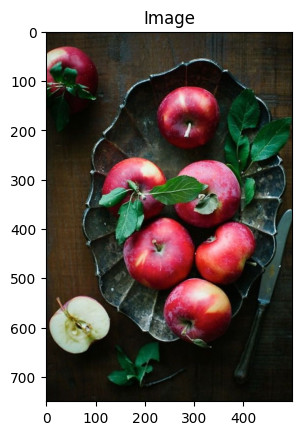

It's an apple


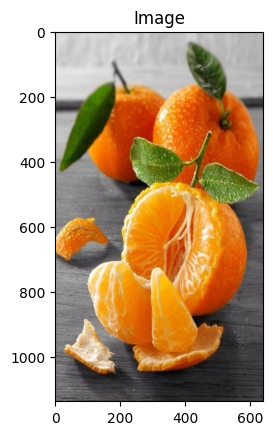

It's an orange


In [38]:
#Prediction over a single image just for fun .. 

for path in [r'E:\Projects\DataSets\archive\Apple vs Orange\Apple\3de97ac83adf09482500a442951b8720.jpg',r'E:\Projects\DataSets\archive\Apple vs Orange\Orange\4c9b3e0bc4f98d884e8b413b1f20bea3.jpg']:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img_array = np.array(img)
    img_array = np.array(img, dtype=np.float32) / 255.0



    plt.imshow(img_rgb)
    plt.title('Image')
    plt.show()
    img_array = np.expand_dims(img_array, axis=0)

    if(model.predict(img_array) > 0.6):
        print("It's an orange")
    else:
        print("It's an apple")
